## Installs

In [2]:
%%capture
# !pip install torch==1.12.0 torchvision==0.13.0 torchaudio==0.12.0
# !pip install pytorch_lightning==2.1
# !pip install pandas librosa opencv-python matplotlib  #cupy-cuda110 
# !pip install -U albumentations
# !pip uninstall opencv-python
# !pip install opencv-python==4.8.0.74
# !pip install timm

## Imports

In [28]:
import pandas as pd
import os
import torch
from IPython.display import display, Audio
import librosa
import math
import numpy as np
import scipy
from scipy import signal as sci_signal
import cv2
import matplotlib.pyplot as plt
import gc
import sys
import re
import numpy as np
from glob import glob
from tqdm import tqdm
import pytorch_lightning as pl
import albumentations as albu
from torchvision.models import efficientnet, vit_b_16
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import pandas as pd
import pandas.api.types
import sklearn.metrics
from sklearn.model_selection import StratifiedKFold
import timm 
import ast
from torch.utils.data import WeightedRandomSampler
import torchaudio

mel_spec_params = {
    "sample_rate": 32000,
    "n_mels": 128,
    "f_min": 20,
    "f_max": 16000,
    "n_fft": 2048,
    "hop_length": 512,
    "normalized": True,
    "center" : True,
    "pad_mode" : "constant",
    "norm" : "slaney",
    "onesided" : True,
    "mel_scale" : "slaney"
}
def normalize_melspec(X, eps=1e-6):
    mean = X.mean((1, 2), keepdim=True)
    std = X.std((1, 2), keepdim=True)
    Xstd = (X - mean) / (std + eps)

    norm_min, norm_max = (
        Xstd.min(-1)[0].min(-1)[0],
        Xstd.max(-1)[0].max(-1)[0],
    )
    fix_ind = (norm_max - norm_min) > eps * torch.ones_like(
        (norm_max - norm_min)
    )
    V = torch.zeros_like(Xstd)
    if fix_ind.sum():
        V_fix = Xstd[fix_ind]
        norm_max_fix = norm_max[fix_ind, None, None]
        norm_min_fix = norm_min[fix_ind, None, None]
        V_fix = torch.max(
            torch.min(V_fix, norm_max_fix),
            norm_min_fix,
        )
        V_fix = (V_fix - norm_min_fix) / (norm_max_fix - norm_min_fix)
        V[fix_ind] = V_fix
    return V

In [29]:
avail_pretrained_models = timm.list_models(pretrained=True)
# avail_pretrained_models

In [30]:
m = timm.create_model('eca_nfnet_l0.ra2_in1k', pretrained=True)

In [31]:
# m

## Configuration

In [32]:
class CONFIG:
    
    # == GENERAL ==
    seed = 42                            # random seed
    device = 'cuda'                         # device to be used
    mix_precision = False                   # whether to use mixed-16 precision
    
    # == DATA ==
    use_holdout = True                                                  # Creates a holdout set
    holdout_path = './holdout_55bottom_20.0%_ratleq3_.csv'  # Path of files from holdout (generated with CreateHoldout.ipynb)
    holdout_noise_val = [0.4, 0.5]                                    # Adds noise to the holdout specs if using holdout ḿin_var, max_var]

    preprocess = True                                                  # If true, will recalculated all center specs for the training set
    preprocessed_data = '../../preprocessed_data/baseline_fastvit'                  # Path for processed data to be stores (Must put on .gitignore to not send to repo)
    checkpoint_dir = '../chpks/baseline_5fold_effnet_timm_melspectrogram'  # Checkpoints path (Must put on .gitignore to not send to repo)
    data_dir_2024 = '../../data/2024'# root folder
    sr = 32000                              # sampling rate
    n_fft = 1095                            # NFFT of Spec.
    win_len = 412                           # WIN_SIZE of Spec.
    hop_len = 100                           # overlap of Spec.
    min_freq = 40                           # min frequency
    max_freq = 15000                        # max frequency
    
    # == MODEL ==
#     model = 'efficientnet_b0'               # model architecture
    model = 'fastvit'
    # == DATASET ==
    batch_size = 32                         # batch size of each step
    n_workers = 4                           # number of workers
    
    # == AUG ==
    USE_HORIZFLIP = True
    USE_XYMASKING = True                    # whether use XYMasking

    # == TRAINING ==
    folds = 7                               # n fold
    epochs = 10                              # max epochs
    lr = 1e-3                               # learning rate
    weight_decay = 1e-5                     # weight decay of optimizer
    visualize = True                        # whether to visualize data and batch

In [33]:
import hashlib
import random
import string

def criar_pasta_com_hash(caminho_pasta):
    if not os.path.exists(caminho_pasta):
        os.makedirs(caminho_pasta)
        return caminho_pasta
    else:
        # Criar uma hash aleatória
        hash_aleatoria = ''.join(random.choices(string.ascii_letters + string.digits, k=8))
        
        # Adicionar a hash ao caminho da pasta
        caminho_pasta_hash = caminho_pasta + "_" + hash_aleatoria
        
        # Criar a pasta com a hash aleatória
        os.makedirs(caminho_pasta_hash)
        
        print(f"Pasta '{caminho_pasta}' já existe. Criada nova pasta com hash aleatória: '{caminho_pasta_hash}'.")
        return caminho_pasta_hash

new_path = criar_pasta_com_hash(CONFIG.checkpoint_dir)
CONFIG.checkpoint_dir = new_path
CONFIG.checkpoint_dir

Pasta '../chpks/baseline_5fold_effnet_timm_melspectrogram' já existe. Criada nova pasta com hash aleatória: '../chpks/baseline_5fold_effnet_timm_melspectrogram_NbrnTP3f'.


'../chpks/baseline_5fold_effnet_timm_melspectrogram_NbrnTP3f'

In [34]:
os.path.exists(CONFIG.checkpoint_dir)

True

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device, ', Using', torch.cuda.device_count(), 'GPU(s)')
pl.seed_everything(CONFIG.seed, workers=True)

Seed set to 42


Device: cuda:0 , Using 1 GPU(s)


42

## Kagle Score

In [36]:
class ParticipantVisibleError(Exception):
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    '''
    Version of macro-averaged ROC-AUC score that ignores all classes that have no true positive labels.
    '''
    del solution[row_id_column_name]
    del submission[row_id_column_name]

    if not pandas.api.types.is_numeric_dtype(submission.values):
        bad_dtypes = {x: submission[x].dtype  for x in submission.columns if not pandas.api.types.is_numeric_dtype(submission[x])}
        raise ParticipantVisibleError(f'Invalid submission data types found: {bad_dtypes}')

    solution_sums = solution.sum(axis=0)
    scored_columns = list(solution_sums[solution_sums > 0].index.values)
    assert len(scored_columns) > 0

    return sklearn.metrics.roc_auc_score(solution[scored_columns].values, submission[scored_columns].values, average='macro')

## Dataframes

In [37]:
df = pd.read_csv(f'{CONFIG.data_dir_2024}/train_metadata.csv')
df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg
2,asbfly,[],['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/175797,asbfly/XC175797.ogg
3,asbfly,[],['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/207738,asbfly/XC207738.ogg
4,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/209218,asbfly/XC209218.ogg


In [38]:
def converter_string_para_lista(string_lista):
    # Remover os colchetes externos
    string_sem_colchetes = string_lista.strip('[]')
    
    # Dividir a string nos separadores ', '
    lista_de_strings = string_sem_colchetes.split(', ')
    
    # Converter cada elemento da lista para seu tipo original usando eval()
    lista_convertida = [eval(elemento) for elemento in lista_de_strings]
    
    return lista_convertida

# Exemplo de uso
string_exemplo = "[1, 2, 3, 'a', 'b', 'c']"
lista_exemplo = converter_string_para_lista(string_exemplo)
print(lista_exemplo)

[1, 2, 3, 'a', 'b', 'c']


In [39]:
# string_exemplo = "[]"
# lista_exemplo = converter_string_para_lista(string_exemplo)
# print(lista_exemplo)

In [40]:
sec = {}

for i, sc in enumerate(df.secondary_labels):
#     print(sc.strip('][').split(', '))
    
    if(len(sc)>2):
        lista_convertida = converter_string_para_lista(sc)
#         list_convertida = []
        sec[i] = lista_convertida
    else:
        sec[i] = []

In [41]:
# sec = list(set(sc))
sec

{0: [],
 1: [],
 2: [],
 3: [],
 4: [],
 5: [],
 6: [],
 7: [],
 8: [],
 9: [],
 10: [],
 11: [],
 12: [],
 13: [],
 14: [],
 15: [],
 16: [],
 17: [],
 18: [],
 19: [],
 20: [],
 21: [],
 22: ['comior1'],
 23: [],
 24: [],
 25: [],
 26: [],
 27: ['asikoe2'],
 28: [],
 29: [],
 30: ['commyn'],
 31: ['asikoe2'],
 32: [],
 33: [],
 34: [],
 35: [],
 36: [],
 37: [],
 38: [],
 39: [],
 40: [],
 41: ['barswa', 'commyn', 'copbar1', 'spodov'],
 42: [],
 43: [],
 44: [],
 45: [],
 46: [],
 47: ['whtkin2'],
 48: [],
 49: [],
 50: [],
 51: [],
 52: [],
 53: [],
 54: [],
 55: [],
 56: ['comtai1'],
 57: [],
 58: [],
 59: ['ashdro1'],
 60: ['grewar3'],
 61: [],
 62: [],
 63: [],
 64: [],
 65: [],
 66: [],
 67: [],
 68: [],
 69: [],
 70: [],
 71: [],
 72: [],
 73: [],
 74: [],
 75: [],
 76: [],
 77: [],
 78: [],
 79: [],
 80: [],
 81: [],
 82: [],
 83: [],
 84: [],
 85: [],
 86: [],
 87: [],
 88: [],
 89: [],
 90: [],
 91: [],
 92: [],
 93: [],
 94: [],
 95: [],
 96: [],
 97: [],
 98: [],
 99: [],


In [42]:
is_there = 0
for s in sec:
    try:
        label2id[s]
        is_there+=1
    except:
        print(f'There is no class {s} in primary label')

There is no class 0 in primary label
There is no class 1 in primary label
There is no class 2 in primary label
There is no class 3 in primary label
There is no class 4 in primary label
There is no class 5 in primary label
There is no class 6 in primary label
There is no class 7 in primary label
There is no class 8 in primary label
There is no class 9 in primary label
There is no class 10 in primary label
There is no class 11 in primary label
There is no class 12 in primary label
There is no class 13 in primary label
There is no class 14 in primary label
There is no class 15 in primary label
There is no class 16 in primary label
There is no class 17 in primary label
There is no class 18 in primary label
There is no class 19 in primary label
There is no class 20 in primary label
There is no class 21 in primary label
There is no class 22 in primary label
There is no class 23 in primary label
There is no class 24 in primary label
There is no class 25 in primary label
There is no class 26 i

In [43]:
is_there

0

Define which data is gonna be used for both Train-Val and Holdout

In [44]:
# READ 2024 TRAIN DATAFRAME AND ADD LABELS
df = pd.read_csv(f'{CONFIG.data_dir_2024}/train_metadata.csv')
df.head()
label_list = sorted(df['primary_label'].unique())
label_id_list = list(range(len(label_list)))
label2id = dict(zip(label_list, label_id_list))
id2label = dict(zip(label_id_list, label_list))
df = df[['primary_label', 'rating', 'filename', 'secondary_labels']].copy() 
df['target'] = df.primary_label.map(label2id)
df['filepath'] = CONFIG.data_dir_2024 + '/train_audio/' + df.filename
df['name'] = df.filename.map(lambda x: x.split('/')[0] + '-' + x.split('/')[-1].split('.')[0])


# CREATE HOLDOUT
if CONFIG.use_holdout:
    holdout_df = pd.read_csv(CONFIG.holdout_path)
    holdout_df = df[df['name'].isin(holdout_df['name'])] 
    train_df = df[~df['name'].isin(holdout_df['name'])] 
    print('> #Holdout Samples: ', len(holdout_df))
    print('> #Training Samples:', len(train_df))
    print(holdout_df)
    print(train_df)
else:
    train_df = df
    print('> #Training Samples:', len(train_df))
    print(train_df)

> #Holdout Samples:  262
> #Training Samples: 24197
      primary_label  rating              filename secondary_labels  target  \
631         asiope1     2.0  asiope1/XC397761.ogg               []       5   
639         aspfly1     1.0  aspfly1/XC210237.ogg               []       6   
642         aspfly1     3.0  aspfly1/XC288095.ogg               []       6   
643         aspfly1     3.0  aspfly1/XC346190.ogg               []       6   
644         aspfly1     2.5  aspfly1/XC400498.ogg      ['asikoe2']       6   
...             ...     ...                   ...              ...     ...   
23919       yebbab1     0.0  yebbab1/XC536074.ogg               []     179   
23931       yebbul3     3.0  yebbul3/XC153288.ogg               []     180   
23939       yebbul3     3.0  yebbul3/XC296416.ogg               []     180   
23940       yebbul3     3.0  yebbul3/XC296444.ogg               []     180   
23948       yebbul3     3.0  yebbul3/XC469480.ogg               []     180   

           

In [45]:
sec = {}

for i, sc in enumerate(train_df.secondary_labels):
#     print(sc.strip('][').split(', '))
    
    if(len(sc)>2):
        lista_convertida = converter_string_para_lista(sc)
        lista_convertida = [label2id[label] for label in lista_convertida if label in label2id.keys()]
        sec[i] = lista_convertida
    else:
        sec[i] = []

In [46]:
len(sec)

24197

In [47]:
sec[0]

[]

## Preprocessing

Generates Image Spectrograms, for both train-val (audio center), and holdout (every 5 seconds of audio)

### Train-Val

In [73]:
def preprocess_fn(filepath):

    # LOAD .OGG
    waveform, sample_rate = torchaudio.load(filepath, normalize=True)
    waveform = waveform[:5*sample_rate]

    transform = torchaudio.transforms.MelSpectrogram(**mel_spec_params)
    spectrogram = transform(waveform)
    db_transform = torchaudio.transforms.AmplitudeToDB(stype='power', top_db=80)
    spectrogram = db_transform(spectrogram)
    
    spec_data = normalize_melspec(spectrogram) * 255

    spec_data = albu.Resize(256, 256)(image=spec_data[0].numpy())
#     print(spec_data['image'].shape)
    return spec_data['image']

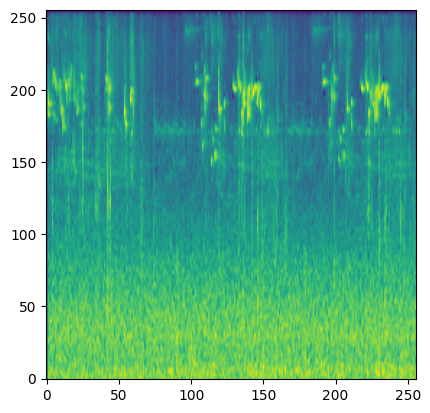

In [74]:
plt.imshow(preprocess_fn(train_df['filepath'][1]), origin='lower')

In [75]:
# PROCESS TRAIN
if not CONFIG.preprocess:
    all_bird_data = np.load(f'{CONFIG.preprocessed_data}/spec_left_5sec_256_256.npy', allow_pickle=True).item()
else:
    all_bird_data = dict()
    for i, row_metadata in tqdm(train_df.iterrows()):
        
        # filepath to processed spec img
        processed_spec = preprocess_fn(row_metadata.filepath)

        all_bird_data[row_metadata.name] = processed_spec.astype(np.float32)

    # save to file
    np.save(os.path.join(CONFIG.preprocessed_data, f'spec_left_5sec_256_256.npy'), all_bird_data)

samples_per_class = train_df['target'].value_counts().sort_index().to_list()

24197it [24:06, 16.73it/s]


In [76]:
len(all_bird_data), all_bird_data[0]

(24197,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

### Holdout

In [47]:
def oog2spec_via_scipy(audio_data):
    # LOAD .OGG
#     waveform, sample_rate = torchaudio.load(filepath, normalize=True)
#     waveform = waveform[:5*sample_rate]

    transform = torchaudio.transforms.MelSpectrogram(**mel_spec_params)
    spectrogram = transform(audio_data)
    db_transform = torchaudio.transforms.AmplitudeToDB(stype='power', top_db=80)
    spectrogram = db_transform(spectrogram)
    
    spec_data = normalize_melspec(spectrogram) * 255
    
    return spec_data

In [48]:
# PROCESS HOLDOUT
if CONFIG.use_holdout:
    all_bird_data_holdout = dict()
    temp_df = pd.DataFrame()
    for i, row in tqdm(holdout_df.iterrows()):
        row_id = row['name']
        file_path = row['filepath']
        audio_data, _ = librosa.load(file_path, sr=CONFIG.sr)
        spec = oog2spec_via_scipy(audio_data)
        pad = 512 - (spec.shape[1] % 512)
        if pad > 0:
            spec = np.pad(spec, ((0,0), (0,pad)))
        spec = spec.reshape(512,-1,512).transpose([0, 2, 1])
#         print(spec.dtype, spec.shape)
        spec = cv2.resize(spec, (256, 256), interpolation=cv2.INTER_NEAREST)
        if len(spec.shape) == 3:
            for j in range(spec.shape[-1]):
                all_bird_data_holdout[f'{row_id}_{(j+1)*5}'] = spec[:, :, j]
                temp_row = row
                temp_row['name'] = f'{row_id}_{(j+1)*5}'
                temp_df = pd.concat([temp_df, temp_row.to_frame().transpose()])
        else:
            j=0
            all_bird_data_holdout[f'{row_id}_{(j+1)*5}'] = spec[:, :]
            temp_row = row
            temp_row['name'] = f'{row_id}_{(j+1)*5}'
            temp_df = pd.concat([temp_df, temp_row.to_frame().transpose()])
    holdout_df = temp_df
    print('> #Holdout Samples: ', len(all_bird_data_holdout))

## Dataset

In [49]:
sc

In [50]:
class BirdDataset(torch.utils.data.Dataset):
    
    def __init__(
        self,
        metadata,
        data,
        secondary_label_map = None,
        augmentation=None,
        holdout_flag=False,
    ):
        super().__init__()
        self.metadata = metadata
        self.augmentation = augmentation
        self.data = data
        self.holdout_flag = holdout_flag
        self.secondary_label_map = secondary_label_map
        
        self.labels = np.eye(182)[self.metadata["target"].astype(int).values]
#         print(self.labels.shape)
#         label2 = df["secondary_labels"].apply(lambda x: self.secondary2target(x)).values
        for i in range(len(self.metadata)):
            if(len(self.secondary_label_map[i]) > 0):
#                 print(self.labels[i,t])
                for t in self.secondary_label_map[i]:
#                     print(t)
#                     print(self.labels[i,t])
                    self.labels[i, t] = 1
        
        
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, index):
        row_metadata = self.metadata.iloc[index]
        
        # load spec. data
        if self.holdout_flag:
            input_spec = self.data[row_metadata['name']]
        else:
            input_spec = self.data[row_metadata.name]
        # aug
        if self.augmentation is not None:
            input_spec = self.augmentation(image=input_spec)['image']
        
        # target
        target = row_metadata.target

        
        
        target2 = None
        if(self.secondary_label_map is not None):
            target2 = self.labels[index] 
        
        return torch.tensor(input_spec, dtype=torch.float32), torch.tensor(target, dtype=torch.long), torch.tensor(target2.astype(np.float32))

In [51]:
def get_transforms(_type):
    
    if _type == 'train':
        return albu.Compose([
#             albu.GaussNoise(var_limit=(0.01, 0.5), mean=0),
            albu.HorizontalFlip(0.5) if CONFIG.USE_XYMASKING else albu.NoOp(),
            albu.XYMasking(
                p=0.3,
                num_masks_x=(1, 3),
                num_masks_y=(1, 3),
                mask_x_length=(1, 10),
                mask_y_length=(1, 20),
            ) if CONFIG.USE_XYMASKING else albu.NoOp()
        ])
    elif _type == 'valid':
        return albu.Compose([])
    elif _type == 'test':
        return albu.Compose([
#             albu.GaussNoise(var_limit=(CONFIG.holdout_noise_val[0], CONFIG.holdout_noise_val[1]), mean=0)
        ])

In [52]:
def show_batch(ds, row=3, col=3):
    fig = plt.figure(figsize=(10, 10))
    img_index = np.random.randint(0, len(ds)-1, row*col)
    
    for i in range(len(img_index)):
        img, label, _ = dummy_dataset[img_index[i]]
        
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        
        ax = fig.add_subplot(row, col, i + 1, xticks=[], yticks=[])
        ax.imshow(img, cmap='jet')
        ax.set_title(f'ID: {img_index[i]}; Target: {label}')
    
    plt.tight_layout()
    plt.show()

In [53]:
dummy_dataset = BirdDataset(train_df, all_bird_data, secondary_label_map = sec, augmentation= get_transforms('train'))

test_input, test_target, onehoted = dummy_dataset[0]
print(test_input.detach().numpy().shape)

show_batch(dummy_dataset)

del dummy_dataset
gc.collect()


In [54]:
if CONFIG.use_holdout:
    dummy_dataset = BirdDataset(holdout_df, all_bird_data_holdout, sec, get_transforms('test'), True)

    test_input, test_target, one_hot = dummy_dataset[0]
    print(test_input.detach().numpy().shape)

    show_batch(dummy_dataset)

    del dummy_dataset
    gc.collect()


In [55]:
one_hot

## Cross-Validation

In [56]:
train_df

In [57]:
kf = StratifiedKFold(n_splits=CONFIG.folds, shuffle=True, random_state=CONFIG.seed)
train_df['fold'] = 0
for fold, (train_idx, val_idx) in enumerate(kf.split(train_df, y=train_df['primary_label'])):
    for idx in val_idx:
        train_df.iloc[idx, train_df.columns.get_loc('fold') ] = fold

In [58]:
from torch.distributions import Beta
class Mixup(nn.Module):
    def __init__(self, mix_beta):

        super(Mixup, self).__init__()
        self.beta_distribution = Beta(mix_beta, mix_beta)

    def forward(self, X, Y, weight=None):

        bs = X.shape[0]
        n_dims = len(X.shape)
        perm = torch.randperm(bs)
        coeffs = self.beta_distribution.rsample(torch.Size((bs,))).to(X.device)

        if n_dims == 2:
            X = coeffs.view(-1, 1) * X + (1 - coeffs.view(-1, 1)) * X[perm]
        elif n_dims == 3:
            X = coeffs.view(-1, 1, 1) * X + (1 - coeffs.view(-1, 1, 1)) * X[perm]
        else:
            X = coeffs.view(-1, 1, 1, 1) * X + (1 - coeffs.view(-1, 1, 1, 1)) * X[perm]

        Y = coeffs.view(-1, 1) * Y + (1 - coeffs.view(-1, 1)) * Y[perm]

        if weight is None:
            return X, Y
        else:
            weight = coeffs.view(-1) * weight + (1 - coeffs.view(-1)) * weight[perm]
            return X, Y, weight

In [59]:
mixup = Mixup(0.5)

In [60]:
test_input.shape, test_target.shape, one_hot.shape

In [61]:
test_target

In [62]:
a, b = mixup(test_input.unsqueeze(0), one_hot.unsqueeze(0))

In [63]:
a.shape, b.shape

In [64]:
b

## Model

In [65]:
avail_pretrained_models = timm.list_models(pretrained=True)
avail_pretrained_models

In [513]:
m = timm.create_model('efficientnet_b0.ra_in1k', pretrained=True, num_classes=182)


In [514]:
# help(timm.create_model)

In [515]:
m

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
      

In [66]:
class EffNet(nn.Module):
    
    def __init__(self, model_type, n_classes, pretrained=True):
        super().__init__()
        
        if model_type == 'efficientnet_b0':
            if pretrained: weights = efficientnet.EfficientNet_B0_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b0(weights=weights)
        elif model_type == 'efficientnet_b1':
            if pretrained: weights = efficientnet.EfficientNet_B1_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b1(weights=weights)
        elif model_type == 'efficientnet_b2':
            if pretrained: weights = efficientnet.EfficientNet_B2_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b2(weights=weights)
        elif model_type == 'efficientnet_b3':
            if pretrained: weights = efficientnet.EfficientNet_B3_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b3(weights=weights)
        elif model_type == 'fastvit':
#             self.base_model = timm.create_model('fastvit_t8.apple_dist_in1k', pretrained=True, num_classes=182)
            self.base_model = timm.create_model('eca_nfnet_l0.ra2_in1k', pretrained=True, num_classes=182)
        else:
            raise ValueError('model type not supported')
        
        if(model_type != 'fastvit'):
            
#         else:
            self.base_model.classifier[1] = nn.Linear(self.base_model.classifier[1].in_features, n_classes, dtype=torch.float32)
    
    
    def forward(self, x):
        x = x.unsqueeze(1)
#         x = torch.cat([x, x, x], dim=3).permute(0, 3, 1, 2)
        x = x.expand(-1, 3, -1, -1)
        return self.base_model(x)

In [67]:
dummy_model = EffNet(CONFIG.model, n_classes=len(label_list))
dummy_input = torch.randn(2, 256, 256)
print(dummy_model(dummy_input).shape)

## Lightning Module

In [68]:
def focal_loss(logits, labels, alpha=None, gamma=2):
    """Compute the focal loss between `logits` and the ground truth `labels`.
    Focal loss = -alpha_t * (1-pt)^gamma * log(pt)
    where pt is the probability of being classified to the true class.
    pt = p (if true class), otherwise pt = 1 - p. p = sigmoid(logit).
    Args:
      logits: A float tensor of size [batch, num_classes].
      labels: A float tensor of size [batch, num_classes].
      alpha: A float tensor of size [batch_size]
        specifying per-example weight for balanced cross entropy.
      gamma: A float scalar modulating loss from hard and easy examples.
    Returns:
      focal_loss: A float32 scalar representing normalized total loss.
    """
    bc_loss = torch.nn.functional.binary_cross_entropy_with_logits(input=logits, target=labels, reduction="none")

    if gamma == 0.0:
        modulator = 1.0
    else:
        modulator = torch.exp(-gamma * labels * logits - gamma * torch.log(1 + torch.exp(-1.0 * logits)))

    loss = modulator * bc_loss

    if alpha is not None:
        weighted_loss = alpha * loss
        focal_loss = torch.sum(weighted_loss)
    else:
        focal_loss = torch.sum(loss)

    focal_loss /= torch.sum(labels)
    return focal_loss

class BalancedCrossEntropyLoss(torch.nn.Module):
    def __init__(
        self,
        samples_per_class=None,
        loss_type: str = "cross_entropy",
        beta: float = 0.999,
        fl_gamma=2,
        class_balanced=True,
    ):
        """
        Compute the Class Balanced Loss between `logits` and the ground truth `labels`.
        Class Balanced Loss: ((1-beta)/(1-beta^n))*Loss(labels, logits)
        where Loss is one of the standard losses used for Neural Networks.
        reference: https://openaccess.thecvf.com/content_CVPR_2019/papers/Cui_Class-Balanced_Loss_Based_on_Effective_Number_of_Samples_CVPR_2019_paper.pdf
        
        Example usage:
        
            # outputs and labels
            logits = torch.tensor([[0.78, 0.1, 0.05]]) # 1 batch, 3 class
            labels = torch.tensor([0]) # 1 batch

            # number of samples per class in the training dataset
            samples_per_class = [30, 100, 25] # 30, 100, 25 samples for labels 0, 1 and 2, respectively

            # class-balanced focal loss
            focal_loss = Loss(
                loss_type="focal_loss",
                samples_per_class=samples_per_class,
                class_balanced=True
            )
            
            loss = focal_loss(logits, labels)
        
        
        Args:
            loss_type: string. One of "focal_loss", "cross_entropy",
                "binary_cross_entropy", "softmax_binary_cross_entropy".
            beta: float. Hyperparameter for Class balanced loss.
            fl_gamma: float. Hyperparameter for Focal loss.
            samples_per_class: A python list of size [num_classes].
                Required if class_balance is True.
            class_balanced: bool. Whether to use class balanced loss.
        Returns:
            BalancedCrossEntropyLoss instance
        """
        super(BalancedCrossEntropyLoss, self).__init__()

        if class_balanced is True and samples_per_class is None:
            raise ValueError("samples_per_class cannot be None when class_balanced is True")

        self.loss_type = loss_type
        self.beta = beta
        self.fl_gamma = fl_gamma
        self.samples_per_class = samples_per_class
        self.class_balanced = class_balanced

    def forward(
        self,
        logits: torch.tensor,
        labels: torch.tensor,
    ):
        """
        Compute the Class Balanced Loss between `logits` and the ground truth `labels`.
        Class Balanced Loss: ((1-beta)/(1-beta^n))*Loss(labels, logits)
        where Loss is one of the standard losses used for Neural Networks.
        Args:
            logits: A float tensor of size [batch, num_classes].
            labels: An int tensor of size [batch].
        Returns:
            cb_loss: A float tensor representing class balanced loss
        """

        batch_size = logits.size(0)
        num_classes = logits.size(1)
        labels_one_hot = torch.nn.functional.one_hot(labels, num_classes).float()

        if self.class_balanced:
            effective_num = 1.0 - np.power(self.beta, self.samples_per_class)
            weights = (1.0 - self.beta) / np.array(effective_num)
            weights = weights / np.sum(weights) * num_classes
            weights = torch.tensor(weights, device=logits.device).float()

            if self.loss_type != "cross_entropy":
                weights = weights.unsqueeze(0)
                weights = weights.repeat(batch_size, 1) * labels_one_hot
                weights = weights.sum(1)
                weights = weights.unsqueeze(1)
                weights = weights.repeat(1, num_classes)
        else:
            weights = None

        if self.loss_type == "focal_loss":
            cb_loss = focal_loss(logits, labels_one_hot, alpha=weights, gamma=self.fl_gamma)
        elif self.loss_type == "cross_entropy":
            cb_loss = torch.nn.functional.cross_entropy(input=logits, target=labels_one_hot, weight=weights)
        elif self.loss_type == "binary_cross_entropy":
            cb_loss = torch.nn.functional.binary_cross_entropy_with_logits(input=logits, target=labels_one_hot, weight=weights)
        elif self.loss_type == "softmax_binary_cross_entropy":
            pred = logits.softmax(dim=1)
            cb_loss = torch.nn.functional.binary_cross_entropy(input=pred, target=labels_one_hot, weight=weights)
        return cb_loss


In [69]:
class BirdModel(pl.LightningModule):
    
    def __init__(self, samples_per_class=None):
        super().__init__()
        
        # == backbone ==
        self.backbone = EffNet(CONFIG.model, n_classes=len(label_list))
        
        self.mixup = Mixup(mix_beta=0.5)
        
        # == loss function ==
#         self.loss_fn = BalancedCrossEntropyLoss(samples_per_class=samples_per_class)  
#         self.loss_fn = nn.BCEWithLogitsLoss(reduction="none")
        self.loss_fn = nn.CrossEntropyLoss()
        # == record ==
        self.validation_step_outputs = []
        
    def forward(self, images):
        return self.backbone(images)
    
    def configure_optimizers(self):
        
        # == define optimizer ==
        model_optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.parameters()),
            lr=CONFIG.lr,
            weight_decay=CONFIG.weight_decay
        )
        
        # == define learning rate scheduler ==
        lr_scheduler = CosineAnnealingWarmRestarts(
            model_optimizer,
            T_0=CONFIG.epochs,
            T_mult=1,
            eta_min=1e-6,
            last_epoch=-1
        )
        
        return {
            'optimizer': model_optimizer,
            'lr_scheduler': {
                'scheduler': lr_scheduler,
                'interval': 'epoch',
                'monitor': 'val_loss',
                'frequency': 1
            }
        }
    
    def training_step(self, batch, batch_idx):
        
        # == obtain input and target ==
        image, target, one_hot = batch
        image = image.to(self.device)
        target = target.to(self.device)
        one_hot = one_hot.to(self.device)
        
#         print(one_hot.sum(dim=-1))
        
        num_classes = 182
#         labels_one_hot = torch.nn.functional.one_hot(target, num_classes).float()
        
#         print(image.shape, labels_one_hot.shape)
#         print(labels_one_hot[0])
        image, target = self.mixup(image, one_hot, None)
        
#         print(image.shape, target.shape)
#         print(target[0])
        # == pred ==
        y_pred = self(image)
        
        # == compute loss ==
        train_loss = self.loss_fn(y_pred, target)
        
        # == record ==
        self.log('train_loss', train_loss, True)
        
        return train_loss
    
    def validation_step(self, batch, batch_idx):
        
        # == obtain input and target ==
        image, target, one_hot = batch
        image = image.to(self.device)
        target = target.to(self.device)
        one_hot = one_hot.to(self.device)
        
        # == pred ==
        with torch.no_grad():
            y_pred = self(image)
            
        self.validation_step_outputs.append({"logits": y_pred, "targets": target})
        
    def train_dataloader(self):
        return self._train_dataloader

    def validation_dataloader(self):
        return self._validation_dataloader
    
    def on_validation_epoch_end(self):
        
        # = merge batch data =
        outputs = self.validation_step_outputs
        
        output_val = nn.Softmax(dim=1)(torch.cat([x['logits'] for x in outputs], dim=0)).cpu().detach()
        target_val = torch.cat([x['targets'] for x in outputs], dim=0).cpu().detach()
        
        # = compute validation loss =
        val_loss = self.loss_fn(output_val, target_val)
        
        # target to one-hot
        target_val = torch.nn.functional.one_hot(target_val, len(label_list))
        
        # = val with ROC AUC =
        gt_df = pd.DataFrame(target_val.numpy().astype(np.float32), columns=label_list)
        pred_df = pd.DataFrame(output_val.numpy().astype(np.float32), columns=label_list)
        
        gt_df['id'] = [f'id_{i}' for i in range(len(gt_df))]
        pred_df['id'] = [f'id_{i}' for i in range(len(pred_df))]
        
        val_score = score(gt_df, pred_df, row_id_column_name='id')
        
        self.log("val_score", val_score, True)
        
        # clear validation outputs
        self.validation_step_outputs = list()
        
        return {'val_loss': val_loss, 'val_score': val_score}

## Training Loop

In [70]:
def predict(data_loader, model):
    model.to(CONFIG.device)
    model.eval()
    predictions = []
    gts = []
    for batch in tqdm(data_loader):
        with torch.no_grad():
            x, y, one_hot_labels = batch
            x = x.cuda()
            outputs = model(x)
            outputs = nn.Softmax(dim=1)(outputs)
        predictions.append(outputs.detach().cpu())
        gts.append(y.detach().cpu())
    
    predictions = torch.cat(predictions, dim=0).cpu().detach()
    gts = torch.cat(gts, dim=0).cpu().detach()
    gts = torch.nn.functional.one_hot(gts, len(label_list))
    return predictions.numpy().astype(np.float32), gts.numpy().astype(np.float32)

In [71]:
def run_training(fold_id, total_df):
    print('================================================================')
    print(f"==== Running training for fold {fold_id} ====")
    
    # == create dataset and dataloader ==
    train_df = total_df[total_df['fold'] != fold_id].copy()
    valid_df = total_df[total_df['fold'] == fold_id].copy()
    
    sec_train = {}
    for i, sc in enumerate(train_df.secondary_labels):
    #     print(sc.strip('][').split(', '))

        if(len(sc)>2):
            lista_convertida = converter_string_para_lista(sc)
            lista_convertida = [label2id[label] for label in lista_convertida if label in label2id.keys()]
            sec_train[i] = lista_convertida
        else:
            sec_train[i] = []
            
    sec_val = {}
    for i, sc in enumerate(train_df.secondary_labels):
    #     print(sc.strip('][').split(', '))

        if(len(sc)>2):
            lista_convertida = converter_string_para_lista(sc)
            lista_convertida = [label2id[label] for label in lista_convertida if label in label2id.keys()]
            sec_val[i] = lista_convertida
        else:
            sec_val[i] = []
    
    
    print(f'Train Samples: {len(train_df)}')
    print(f'Valid Samples: {len(valid_df)}')
    
    
    # == create a sampler that samples inversely of its counts ==
    y_train = train_df['target']
    class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in y_train])
    samples_weight = torch.from_numpy(samples_weight)
    
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight)*5)
    
    
    train_ds = BirdDataset(train_df, all_bird_data, sec_train, get_transforms('train'), False)
    val_ds = BirdDataset(valid_df, all_bird_data, sec_val, get_transforms('valid'), False)
    
    train_dl = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CONFIG.batch_size,
        shuffle=False,
        num_workers=CONFIG.n_workers,
        pin_memory=True,
        persistent_workers=True,
        sampler=sampler
    )
    
    val_dl = torch.utils.data.DataLoader(
        val_ds,
        batch_size=CONFIG.batch_size * 2,
        shuffle=False,
        num_workers=CONFIG.n_workers,
        pin_memory=True,
        persistent_workers=True
    )
    
    print(train_df['target'].value_counts().sort_index().values, len(train_df['target'].value_counts().sort_index().values))
    samples_per_class = list(train_df['target'].value_counts().sort_index().values)
    
    # == init model ==
    bird_model = BirdModel(samples_per_class)
    
    # == init callback ==
    checkpoint_callback = ModelCheckpoint(monitor='val_score',
                                          dirpath=CONFIG.checkpoint_dir,
                                          save_top_k=1,
                                          save_last=False,
                                          save_weights_only=True,
                                          filename=f"fold_{fold_id}",
                                          mode='max')
    callbacks_to_use = [checkpoint_callback, TQDMProgressBar(refresh_rate=1)]
    
    # == init trainer ==
    trainer = pl.Trainer(
        max_epochs=CONFIG.epochs,
        val_check_interval=0.5,
        callbacks=callbacks_to_use,
        enable_model_summary=False,
        accelerator="gpu",
        deterministic=True,
        precision='16-mixed' if CONFIG.mix_precision else 32,
    )
    
    # == Training ==
    trainer.fit(bird_model, train_dataloaders=train_dl, val_dataloaders=val_dl)
    
    # == Prediction ==
    best_model_path = checkpoint_callback.best_model_path
    weights = torch.load(best_model_path)['state_dict']
    bird_model.load_state_dict(weights)
    
    preds, gts = predict(val_dl, bird_model)
    
    # = create dataframe =
    pred_df = pd.DataFrame(preds, columns=label_list)
    pred_df['id'] = np.arange(len(pred_df))
    gt_df = pd.DataFrame(gts, columns=label_list)
    gt_df['id'] = np.arange(len(gt_df))
    
    # = compute score =
    val_score = score(gt_df, pred_df, row_id_column_name='id')
    
    # == save to file ==
    pred_cols = [f'pred_{t}' for t in label_list]
    valid_df = pd.concat([valid_df.reset_index(), pd.DataFrame(np.zeros((len(valid_df), len(label_list)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)
    valid_df[label_list] = gts
    valid_df[pred_cols] = preds
    valid_df.to_csv(f"{CONFIG.checkpoint_dir}/pred_df_f{fold_id}.csv", index=False)
    
    return preds, gts, val_score

In [72]:
def run_holdout(f, holdout_df):
#     torch.manual_seed(42)
    samples_per_class = list(holdout_df['target'].value_counts().sort_index().values)
    
    # == init model ==
    bird_model = BirdModel(samples_per_class)
    
    weights = torch.load(os.path.join(CONFIG.checkpoint_dir, 'fold_' + str(f) + '.ckpt'), map_location=torch.device('cpu'))['state_dict']
    bird_model.load_state_dict(weights)    
    bird_model.eval()
    
    sec_holdout = {}
    for i, sc in enumerate(holdout_df.secondary_labels):
    #     print(sc.strip('][').split(', '))

        if(len(sc)>2):
            lista_convertida = converter_string_para_lista(sc)
            lista_convertida = [label2id[label] for label in lista_convertida if label in label2id.keys()]
            sec_holdout[i] = lista_convertida
        else:
            sec_holdout[i] = []
    
    test_dataset = BirdDataset(holdout_df, all_bird_data_holdout, sec_holdout, get_transforms('test'), True)
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=CONFIG.batch_size * 2,
        shuffle=False,
        num_workers=CONFIG.n_workers,
        pin_memory=True,
        persistent_workers=True
    )
    preds, gts = predict(test_loader, bird_model)
    pred_df = pd.DataFrame(preds, columns=label_list)
    pred_df['id'] = np.arange(len(pred_df))
    gt_df = pd.DataFrame(gts, columns=label_list)
    gt_df['id'] = np.arange(len(gt_df))
    holdout_score = score(gt_df, pred_df, row_id_column_name='id')
    pred_cols = [f'pred_{t}' for t in label_list]
    holdout_df = pd.concat([holdout_df.reset_index(), pd.DataFrame(np.zeros((len(holdout_df), len(label_list)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)
    holdout_df[label_list] = gts
    holdout_df[pred_cols] = preds
    holdout_df.to_csv(f"{CONFIG.checkpoint_dir}/holdout_pred_df_f{f}.csv", index=False)
    return preds, gts, holdout_score

## RUN

In [ ]:
# training
torch.set_float32_matmul_precision('high')
torch.manual_seed(42)


# record
fold_val_score_list = list()
oof_df = train_df.copy()
pred_cols = [f'pred_{t}' for t in label_list]
oof_df = pd.concat([oof_df, pd.DataFrame(np.zeros((len(oof_df), len(pred_cols)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)

if CONFIG.use_holdout:
    # record
    fold_test_score_list = list()
    holdout_df.index = range(len(holdout_df))
    ood_df = holdout_df.copy()
    pred_cols = [f'pred_{t}' for t in label_list]
    hold_idx = holdout_df.index
    ood_df = pd.concat([ood_df, pd.DataFrame(np.zeros((len(ood_df), len(pred_cols)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)
    hold_predictions = list()

for f in range(CONFIG.folds):
    
    # get validation index
    val_idx = list(train_df[train_df['fold'] == f].index)
    
    # main loop of f-fold
    val_preds, val_gts, val_score = run_training(f, train_df)
    oof_df.loc[val_idx, label_list] = val_gts
    oof_df.loc[val_idx, pred_cols] = val_preds
    fold_val_score_list.append(val_score)

    if CONFIG.use_holdout:
        # Holdout Fold Inference
        hold_preds, hold_gts, hold_score = run_holdout(f, holdout_df)
        ood_df.loc[hold_idx, label_list] = hold_gts
        ood_df.loc[hold_idx, pred_cols] = hold_preds
        fold_test_score_list.append(hold_score)
        hold_predictions.append(hold_preds)

for idx, val_score in enumerate(fold_val_score_list):
    print(f'Fold {idx} Val Score: {val_score:.5f}')
oof_df.to_csv(f"{CONFIG.checkpoint_dir}/oof_pred.csv", index=False)

# Holdout Score
if CONFIG.use_holdout:

    for idx, hold_score in enumerate(fold_test_score_list):
        print(f'Fold {idx} Holdout Score: {hold_score:.5f}')
    
    ood_df.to_csv(f"{CONFIG.checkpoint_dir}/ood_pred.csv", index=False)

    ensemble_df = holdout_df.copy()
    pred_cols = [f'pred_{t}' for t in label_list]
    ensemble_df = pd.concat([ensemble_df, pd.DataFrame(np.zeros((len(ensemble_df), len(pred_cols)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)
    ensemble_predictions = np.mean(hold_predictions, axis=0)
    pred_df = pd.DataFrame(ensemble_predictions, columns=label_list)
    pred_df['id'] = np.arange(len(pred_df))
    gt_df = pd.DataFrame(hold_gts, columns=label_list)
    gt_df['id'] = np.arange(len(gt_df))
    holdout_score = score(gt_df, pred_df, row_id_column_name='id')
    print('Ensemble Score', holdout_score)
    ensemble_df.loc[hold_idx, label_list] = hold_gts
    ensemble_df.loc[hold_idx, pred_cols] = ensemble_predictions
    ensemble_df.to_csv(f"{CONFIG.checkpoint_dir}/holdout_ensemble_result.csv", index=False)

==== Running training for fold 0 ====
Train Samples: 20740
Valid Samples: 3457
[ 90  93  82  39 236   3  16  17  17 428 429  17  20 229 429 107   4 198
 121 149 428   6  25   9  73   9 104 129  98  13  68  49  24 180  15  65
  23 428 188 429 428 203  60 429 429 258 107  15  34   8 131  15   5 429
  45 429  18 428  38 140  91  40 428  58 139 237  50  31  44  35 429 428
 122 238  38  15 428  99 186  15 429 119 429  50  52  38  23  10  34   7
  54  31   2   9  16  68  10  42 232  12 202  97  77  17  25 428 348 428
 106  66  13  26  13   8   2  79  39  16   7   2  99  35  61  40   5  77
 117  33  12 132  24   6 235  48 107  26 192  10 170  87 162 115 173 360
  51  14 109  32   6  22   9  82  12  36  39 133  22  16 105  17  88  89
  17  27  24   6 234  45  19  13  29 143  64  48 194  54 158 429   3  21
  22 429] 182


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

In [536]:
# torch.manual_seed(42)
if CONFIG.use_holdout:
    # record
    fold_test_score_list = list()
    holdout_df.index = range(len(holdout_df))
    ood_df = holdout_df.copy()
    pred_cols = [f'pred_{t}' for t in label_list]
    hold_idx = holdout_df.index
    ood_df = pd.concat([ood_df, pd.DataFrame(np.zeros((len(ood_df), len(pred_cols)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)
    hold_predictions = list()

for f in range(CONFIG.folds):
# for f in [1,2,4]:
    hold_preds, hold_gts, hold_score = run_holdout(f, holdout_df)
    ood_df.loc[hold_idx, label_list] = hold_gts
    ood_df.loc[hold_idx, pred_cols] = hold_preds
    fold_test_score_list.append(hold_score)
    hold_predictions.append(hold_preds)

# 5 FOLD SEED 42 with Adam and gaussiannoise
for idx, hold_score in enumerate(fold_test_score_list):
    print(f'Fold {idx} Holdout Score: {hold_score:.5f}')

# ood_df.to_csv(f"{CONFIG.checkpoint_dir}/ood_pred.csv", index=False)

ensemble_df = holdout_df.copy()
pred_cols = [f'pred_{t}' for t in label_list]
ensemble_df = pd.concat([ensemble_df, pd.DataFrame(np.zeros((len(ensemble_df), len(pred_cols)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)
ensemble_predictions = np.mean(hold_predictions, axis=0)
pred_df = pd.DataFrame(ensemble_predictions, columns=label_list)
pred_df['id'] = np.arange(len(pred_df))
gt_df = pd.DataFrame(hold_gts, columns=label_list)
gt_df['id'] = np.arange(len(gt_df))
holdout_score = score(gt_df, pred_df, row_id_column_name='id')
print('Ensemble Score', holdout_score)


100%|█████████████████████████████████████████████████████████████████████████████████| 201/201 [00:16<00:00, 11.84it/s]

 28%|███████████████████████▎                                                          | 57/201 [00:05<00:11, 12.57it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 201/201 [00:18<00:00, 10.88it/s]

 58%|███████████████████████████████████████████████▏                                 | 117/201 [00:10<00:06, 12.67it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 201/201 [00:16<00:00, 11.83it/s]

 89%|███████████████████████████████████████████████████████████████████████▋         | 178/201 [00:15<00:01, 12.76it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 201/201 [00:16<00:00, 11.90it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 201/201 [00:16<00:00, 11.98it/s]

 17%|█████████████▊                                                                    | 34/201 [00:03<00:12, 12.92it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 201/201 [00:16<00:00, 12.03it/s]

 47%|██████████████████████████████████████▎                                           | 94/201 [00:08<00:08, 12.98it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 201/201 [00:16<00:00, 12.10it/s]


Fold 0 Holdout Score: 0.77785
Fold 1 Holdout Score: 0.78057
Fold 2 Holdout Score: 0.77921
Fold 3 Holdout Score: 0.75878
Fold 4 Holdout Score: 0.81267
Fold 5 Holdout Score: 0.78549
Fold 6 Holdout Score: 0.76561
Ensemble Score 0.8331260600135477


In [328]:
# torch.manual_seed(42)
if CONFIG.use_holdout:
    # record
    fold_test_score_list = list()
    holdout_df.index = range(len(holdout_df))
    ood_df = holdout_df.copy()
    pred_cols = [f'pred_{t}' for t in label_list]
    hold_idx = holdout_df.index
    ood_df = pd.concat([ood_df, pd.DataFrame(np.zeros((len(ood_df), len(pred_cols)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)
    hold_predictions = list()

# for f in range(CONFIG.folds):
for f in [1,2,4]:
    hold_preds, hold_gts, hold_score = run_holdout(f, holdout_df)
    ood_df.loc[hold_idx, label_list] = hold_gts
    ood_df.loc[hold_idx, pred_cols] = hold_preds
    fold_test_score_list.append(hold_score)
    hold_predictions.append(hold_preds)

# 5 FOLD SEED 42 with Adam and gaussiannoise
for idx, hold_score in enumerate(fold_test_score_list):
    print(f'Fold {idx} Holdout Score: {hold_score:.5f}')

# ood_df.to_csv(f"{CONFIG.checkpoint_dir}/ood_pred.csv", index=False)

ensemble_df = holdout_df.copy()
pred_cols = [f'pred_{t}' for t in label_list]
ensemble_df = pd.concat([ensemble_df, pd.DataFrame(np.zeros((len(ensemble_df), len(pred_cols)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)
ensemble_predictions = np.mean(hold_predictions, axis=0)
pred_df = pd.DataFrame(ensemble_predictions, columns=label_list)
pred_df['id'] = np.arange(len(pred_df))
gt_df = pd.DataFrame(hold_gts, columns=label_list)
gt_df['id'] = np.arange(len(gt_df))
holdout_score = score(gt_df, pred_df, row_id_column_name='id')
print('Ensemble Score', holdout_score)


100%|███████████████████████████████████████████████████████████████████████████████████| 22/22 [00:02<00:00,  8.38it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 22/22 [00:02<00:00,  8.35it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 22/22 [00:02<00:00,  8.41it/s]


Fold 0 Holdout Score: 0.81320
Fold 1 Holdout Score: 0.79183
Fold 2 Holdout Score: 0.82968
Ensemble Score 0.8407182641935449


In [ ]:
def calcular_media_pesos(checkpoint_paths):
    pesos_totais = None
    num_checkpoints = len(checkpoint_paths)
    for checkpoint_path in checkpoint_paths:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        if pesos_totais is None:
            pesos_totais = checkpoint['state_dict']
        else:
            for key in pesos_totais.keys():
                pesos_totais[key] += checkpoint['state_dict'][key]
    
    pesos_media = {key: value / num_checkpoints for key, value in pesos_totais.items()}
    return pesos_media

ckpt_list = glob(f'{CONFIG.checkpoint_dir}/*.ckpt')
print(f'find {len(ckpt_list)} ckpts in {CONFIG.checkpoint_dir}.')
#ckpt_list = [ckpt_list[-1]]

chpk_medio = calcular_media_pesos(ckpt_list)

samples_per_class = list(holdout_df['target'].value_counts().sort_index().values)
    
    # == init model ==
bird_model = BirdModel(samples_per_class)

# weights = torch.load(os.path.join(CONFIG.checkpoint_dir, 'fold_' + str(f) + '.ckpt'), map_location=torch.device('cpu'))['state_dict']
bird_model.load_state_dict(chpk_medio)    
bird_model.eval()

test_dataset = BirdDataset(holdout_df, all_bird_data_holdout, get_transforms('test'), True)
test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=CONFIG.batch_size * 2,
        shuffle=False,
        num_workers=CONFIG.n_workers,
        pin_memory=True,
        persistent_workers=True
    )
preds, gts = predict(test_loader, bird_model)
pred_df = pd.DataFrame(preds, columns=label_list)
pred_df['id'] = np.arange(len(pred_df))
gt_df = pd.DataFrame(gts, columns=label_list)
gt_df['id'] = np.arange(len(gt_df))
holdout_score = score(gt_df, pred_df, row_id_column_name='id')

print(f"ModelSoup score = {holdout_score}")

In [ ]:
# torch.manual_seed(42)
if CONFIG.use_holdout:
    # record
    fold_test_score_list = list()
    holdout_df.index = range(len(holdout_df))
    ood_df = holdout_df.copy()
    pred_cols = [f'pred_{t}' for t in label_list]
    hold_idx = holdout_df.index
    ood_df = pd.concat([ood_df, pd.DataFrame(np.zeros((len(ood_df), len(pred_cols)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)
    hold_predictions = list()

for f in range(CONFIG.folds):    
    hold_preds, hold_gts, hold_score = run_holdout(f, holdout_df)
    ood_df.loc[hold_idx, label_list] = hold_gts
    ood_df.loc[hold_idx, pred_cols] = hold_preds
    fold_test_score_list.append(hold_score)
    hold_predictions.append(hold_preds)

# 5 FOLD SEED 42 with Adam and gaussiannoise
for idx, hold_score in enumerate(fold_test_score_list):
    print(f'Fold {idx} Holdout Score: {hold_score:.5f}')

# ood_df.to_csv(f"{CONFIG.checkpoint_dir}/ood_pred.csv", index=False)

ensemble_df = holdout_df.copy()
pred_cols = [f'pred_{t}' for t in label_list]
ensemble_df = pd.concat([ensemble_df, pd.DataFrame(np.zeros((len(ensemble_df), len(pred_cols)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)
ensemble_predictions = np.mean(hold_predictions, axis=0)
pred_df = pd.DataFrame(ensemble_predictions, columns=label_list)
pred_df['id'] = np.arange(len(pred_df))
gt_df = pd.DataFrame(hold_gts, columns=label_list)
gt_df['id'] = np.arange(len(gt_df))
holdout_score = score(gt_df, pred_df, row_id_column_name='id')
print('Ensemble Score', holdout_score)

In [74]:
# torch.manual_seed(42)
if CONFIG.use_holdout:
    # record
    fold_test_score_list = list()
    holdout_df.index = range(len(holdout_df))
    ood_df = holdout_df.copy()
    pred_cols = [f'pred_{t}' for t in label_list]
    hold_idx = holdout_df.index
    ood_df = pd.concat([ood_df, pd.DataFrame(np.zeros((len(ood_df), len(pred_cols)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)
    hold_predictions = list()

for f in range(CONFIG.folds):    
    hold_preds, hold_gts, hold_score = run_holdout(f, holdout_df)
    ood_df.loc[hold_idx, label_list] = hold_gts
    ood_df.loc[hold_idx, pred_cols] = hold_preds
    fold_test_score_list.append(hold_score)
    hold_predictions.append(hold_preds)

# 5 FOLD SEED 42 with Adam and gaussiannoise
for idx, hold_score in enumerate(fold_test_score_list):
    print(f'Fold {idx} Holdout Score: {hold_score:.5f}')

# ood_df.to_csv(f"{CONFIG.checkpoint_dir}/ood_pred.csv", index=False)

ensemble_df = holdout_df.copy()
pred_cols = [f'pred_{t}' for t in label_list]
ensemble_df = pd.concat([ensemble_df, pd.DataFrame(np.zeros((len(ensemble_df), len(pred_cols)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)
ensemble_predictions = np.mean(hold_predictions, axis=0)
pred_df = pd.DataFrame(ensemble_predictions, columns=label_list)
pred_df['id'] = np.arange(len(pred_df))
gt_df = pd.DataFrame(hold_gts, columns=label_list)
gt_df['id'] = np.arange(len(gt_df))
holdout_score = score(gt_df, pred_df, row_id_column_name='id')
print('Ensemble Score', holdout_score)


100%|███████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.59it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.57it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.08it/s]


Fold 0 Holdout Score: 0.83625
Fold 1 Holdout Score: 0.81498
Fold 2 Holdout Score: 0.84289
Fold 3 Holdout Score: 0.82205
Fold 4 Holdout Score: 0.83979
Ensemble Score 0.861349936094777


In [75]:
!pip install onnxruntime

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 6.8 MB 846 kB/s eta 0:00:01
     |████████████████████████████████| 46 kB 26.7 MB/s eta 0:00:01
     |████████████████████████████████| 86 kB 32.5 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [540]:
ckpt_list = glob(f'{CONFIG.checkpoint_dir}/*.ckpt')
print(f'find {len(ckpt_list)} ckpts in {CONFIG.checkpoint_dir}.')
#ckpt_list = [ckpt_list[-1]]
ckpt_list

find 7 ckpts in ../chpks/baseline_7fold_effb0timm_10epochs.


['../chpks/baseline_7fold_effb0timm_10epochs/fold_2.ckpt',
 '../chpks/baseline_7fold_effb0timm_10epochs/fold_3.ckpt',
 '../chpks/baseline_7fold_effb0timm_10epochs/fold_4.ckpt',
 '../chpks/baseline_7fold_effb0timm_10epochs/fold_1.ckpt',
 '../chpks/baseline_7fold_effb0timm_10epochs/fold_0.ckpt',
 '../chpks/baseline_7fold_effb0timm_10epochs/fold_5.ckpt',
 '../chpks/baseline_7fold_effb0timm_10epochs/fold_6.ckpt']

In [541]:
CONFIG.checkpoint_dir

'../chpks/baseline_7fold_effb0timm_10epochs'

In [542]:
# == setting of onnx ==

input_tensor = torch.randn(64, 224, 224)  # input shape
input_names = ['x']
output_names = ['output']

In [543]:
onnx_ckpt_list = list()
for ckpt_path in ckpt_list:
    ckpt_name = os.path.basename(ckpt_path).split('.')[0]
    # == init model ==
    bird_model = BirdModel()
    
    # == load ckpt ==
    weights = torch.load(ckpt_path, map_location=torch.device('cpu'))['state_dict']
    bird_model.load_state_dict(weights)
    bird_model.eval()
    
    # == convert to onnx ==
    torch.onnx.export(bird_model.backbone, input_tensor, f"{CONFIG.checkpoint_dir}/{ckpt_name}.onnx", verbose=False, input_names=input_names, output_names=output_names)
#     onnx_ckpt_list.append(f"{ckpt_name}.onnx")

In [ ]:
Ensemble Score 0.7905249702909269

In [ ]:
Ensemble Score 0.7225110412759088

In [ ]:
Ensemble Score 0.758961861035261

In [ ]:
# 5 FOLD SEED 42 with AdamW and gaussiannoise
for idx, hold_score in enumerate(fold_test_score_list):
    print(f'Fold {idx} Holdout Score: {hold_score:.5f}')

# ood_df.to_csv(f"{CONFIG.checkpoint_dir}/ood_pred.csv", index=False)

ensemble_df = holdout_df.copy()
pred_cols = [f'pred_{t}' for t in label_list]
ensemble_df = pd.concat([ensemble_df, pd.DataFrame(np.zeros((len(ensemble_df), len(pred_cols)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)
ensemble_predictions = np.mean(hold_predictions, axis=0)
pred_df = pd.DataFrame(ensemble_predictions, columns=label_list)
pred_df['id'] = np.arange(len(pred_df))
gt_df = pd.DataFrame(hold_gts, columns=label_list)
gt_df['id'] = np.arange(len(gt_df))
holdout_score = score(gt_df, pred_df, row_id_column_name='id')
print('Ensemble Score', holdout_score)

In [ ]:
# 5 FOLD SEED 42 with AdamW and gaussiannoise softmax
for idx, hold_score in enumerate(fold_test_score_list):
    print(f'Fold {idx} Holdout Score: {hold_score:.5f}')

# ood_df.to_csv(f"{CONFIG.checkpoint_dir}/ood_pred.csv", index=False)

def softmax(x, temperature=2):
    exp_x = np.exp(x/temperature)
    return exp_x / np.sum(exp_x)

ensemble_df = holdout_df.copy()
pred_cols = [f'pred_{t}' for t in label_list]
ensemble_df = pd.concat([ensemble_df, pd.DataFrame(np.zeros((len(ensemble_df), len(pred_cols)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)
# ensemble_predictions = softmax(np.sum(hold_predictions, axis=0))
# ensemble_predictions = np.median(hold_predictions, axis=0)

tot = np.sum(fold_test_score_list)
ensemble_predictions = fold_test_score_list[0]*hold_predictions[0]/tot + fold_test_score_list[1]*hold_predictions[1]/tot + fold_test_score_list[2]*hold_predictions[2]/tot + fold_test_score_list[3]*hold_predictions[3]/tot + fold_test_score_list[4]*hold_predictions[4]/tot

pred_df = pd.DataFrame(ensemble_predictions, columns=label_list)
pred_df['id'] = np.arange(len(pred_df))
gt_df = pd.DataFrame(hold_gts, columns=label_list)
gt_df['id'] = np.arange(len(gt_df))
holdout_score = score(gt_df, pred_df, row_id_column_name='id')
print('Ensemble Score', holdout_score)

In [ ]:
# 5 FOLD SEED 42
for idx, hold_score in enumerate(fold_test_score_list):
    print(f'Fold {idx} Holdout Score: {hold_score:.5f}')

# ood_df.to_csv(f"{CONFIG.checkpoint_dir}/ood_pred.csv", index=False)

ensemble_df = holdout_df.copy()
pred_cols = [f'pred_{t}' for t in label_list]
ensemble_df = pd.concat([ensemble_df, pd.DataFrame(np.zeros((len(ensemble_df), len(pred_cols)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)
ensemble_predictions = np.mean(hold_predictions, axis=0)
pred_df = pd.DataFrame(ensemble_predictions, columns=label_list)
pred_df['id'] = np.arange(len(pred_df))
gt_df = pd.DataFrame(hold_gts, columns=label_list)
gt_df['id'] = np.arange(len(gt_df))
holdout_score = score(gt_df, pred_df, row_id_column_name='id')
print('Ensemble Score', holdout_score)

In [ ]:
# 3 FOLD SEED 42
for idx, hold_score in enumerate(fold_test_score_list):
    print(f'Fold {idx} Holdout Score: {hold_score:.5f}')

# ood_df.to_csv(f"{CONFIG.checkpoint_dir}/ood_pred.csv", index=False)

ensemble_df = holdout_df.copy()
pred_cols = [f'pred_{t}' for t in label_list]
ensemble_df = pd.concat([ensemble_df, pd.DataFrame(np.zeros((len(ensemble_df), len(pred_cols)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)
ensemble_predictions = np.mean(hold_predictions, axis=0)
pred_df = pd.DataFrame(ensemble_predictions, columns=label_list)
pred_df['id'] = np.arange(len(pred_df))
gt_df = pd.DataFrame(hold_gts, columns=label_list)
gt_df['id'] = np.arange(len(gt_df))
holdout_score = score(gt_df, pred_df, row_id_column_name='id')
print('Ensemble Score', holdout_score)

In [ ]:
# 3 FOLD SEED 1917
for idx, hold_score in enumerate(fold_test_score_list):
    print(f'Fold {idx} Holdout Score: {hold_score:.5f}')

# ood_df.to_csv(f"{CONFIG.checkpoint_dir}/ood_pred.csv", index=False)

ensemble_df = holdout_df.copy()
pred_cols = [f'pred_{t}' for t in label_list]
ensemble_df = pd.concat([ensemble_df, pd.DataFrame(np.zeros((len(ensemble_df), len(pred_cols)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)
ensemble_predictions = np.mean(hold_predictions, axis=0)
pred_df = pd.DataFrame(ensemble_predictions, columns=label_list)
pred_df['id'] = np.arange(len(pred_df))
gt_df = pd.DataFrame(hold_gts, columns=label_list)
gt_df['id'] = np.arange(len(gt_df))
holdout_score = score(gt_df, pred_df, row_id_column_name='id')
print('Ensemble Score', holdout_score)

In [ ]:
ensemble_df.filename.nunique()

In [ ]:
pred_df = pd.DataFrame(ensemble_predictions, columns=label_list)
pred_df['id'] = np.arange(len(pred_df))

In [ ]:
orig_cols = pred_df.columns

In [ ]:
len(orig_cols)

In [ ]:
def generate_unique_labels(total_examples, group_size):
    labels = []
    unique_label = 0
    for i in range(total_examples):
        if i % group_size == 0:
            unique_label += 1
        labels.append(unique_label)
    return labels

# Exemplo de uso:
total_examples = len(pred_df)
# total_examples = 100

string_to_int = {string: i for i, string in enumerate(ensemble_df.filename.unique())}


group_size = 48
labels = generate_unique_labels(total_examples, group_size)
pred_df['unique_id'] = ensemble_df.filename.map(string_to_int)
pred_df.head()

In [ ]:
def max_column(row):
    max_value = row.max()
    max_column = row.idxmax()
    return pd.Series({'max_value': max_value, 'max_column': max_column})

# Aplicar a função em cada linha do DataFrame
max_values = pred_df[label_list].apply(max_column, axis=1)

# Adicionar as novas colunas ao DataFrame original
pred_df['max_value'] = max_values['max_value']
pred_df['max_column'] = max_values['max_column']

pred_df.head(5)

In [ ]:
def unique_values(x):
    return len(x.unique())


pred_df.groupby('unique_id').agg({'max_column': unique_values}).reset_index()

In [ ]:
nunique = pred_df.groupby('unique_id').agg({'max_column': unique_values}).reset_index()
nunique['niq'] = nunique['max_column']

pred_df = pred_df.merge(nunique, on='unique_id', how='left')

pred_df.head(5)

In [ ]:
def mode_values(x):
    return x.mode().iloc[0]

modes = pred_df.groupby('unique_id').agg({'max_column_x': unique_values, 'max_column_x': mode_values}).reset_index()

pred_df = pred_df.merge(modes, on='unique_id', how='left')

pred_df.head(5)

In [ ]:
pred_df.groupby('unique_id').agg({'max_column_y': unique_values}).reset_index() # Just confirming

In [ ]:
# sum_values = sub[(sub['unique_id'] == 1)&(sub['max_column_x'] == sub['max_column_y'])][label_list].sum(axis=0)

t = 1

# Calcular a softmax das somas
def softmax(x, temperature):
    exp_x = np.exp(x/temperature)
    return exp_x / np.sum(exp_x)

sub_ = pred_df.copy()

for i in range(0,sub_['unique_id'].nunique()):
    # Only the mode
#     print(i)
    if((sub_[sub_['unique_id'] == i]['niq'].values[0] > 48) & (sub_[sub_['unique_id'] == i]['niq'].values[0] < 24)):
#         print(sub_[sub_['unique_id'] == i]['niq'].values[0])
        sum_df = sub_[(sub_['unique_id'] == i)&(sub_['max_column_x_x'] == sub_['max_column_x_y'])].sort_values(by='max_value', ascending=False).reset_index().head(2)
        
        sum_values = sum_df[label_list].sum(axis = 0)
        # Mean softmax
    #     sum_values = sub[(sub['unique_id'] == i)][label_list].sum(axis=0)

        softmax_values = softmax(sum_values, temperature = t)
        softmax_values =  softmax_values.values
    #     softmax_values = np.array(softmax_values)
#         softmax_values.shape, softmax_values.sum()
        sub_.loc[sub_['unique_id'] == i, label_list] = softmax_values
#     elif(sub_[sub_['unique_id'] == i]['niq'].values[0] < 24):
    else:
        sum_df = sub_[(sub_['unique_id'] == i)].sort_values(by='max_value', ascending=False).reset_index().head(1)
        sum_values = sum_df[label_list].values
#         print(sum_values)
        sub_.loc[sub_['unique_id'] == i, label_list] = sum_values

In [ ]:
len(label_list)

In [ ]:
def max_column(row):
    max_value = row.max()
    max_column = row.idxmax()
    return pd.Series({'max_value': max_value, 'max_column': max_column})

# Aplicar a função em cada linha do DataFrame
max_values = sub_[label_list].apply(max_column, axis=1)

# Adicionar as novas colunas ao DataFrame original
sub_['max_value_post'] = max_values['max_value']
sub_['max_column_post'] = max_values['max_column']

sub_['label_list'] = list(np.argmax(hold_gts, axis=1))
sub_['label_list'] = sub_['label_list'].map(id2label)
sub_.head(10)

In [ ]:
sub_.tail(20)

In [ ]:
sub_[label_list].sum(axis=1).sum()

In [ ]:
sub_['id'] = np.arange(len(pred_df))
gt_df['id'] = np.arange(len(pred_df))

new_list = label_list.copy()
new_list.append('id')

holdout_score = score(gt_df, sub_[new_list], row_id_column_name='id')
holdout_score